# InfoGAN

In [16]:
import os
import tensorflow
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense,Reshape, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization,Activation,Embedding,multiply
from tensorflow.keras.layers import Conv2DTranspose,Flatten, LeakyReLU, concatenate
from tensorflow.keras.datasets import mnist
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

### Load the data

In [2]:
from tensorflow.keras.datasets import mnist
(xtr,ytr),_ = mnist.load_data()
xtr = xtr.reshape((-1,28,28,1)).astype('float32')/255
ytr = to_categorical(ytr)

### Create a dataViewer

In [3]:
from GAN.utils import dataViewer

In [4]:
%matplotlib inline
from GAN.utils import dataViewer

In [5]:
def viewMnist(mtr):
    '''Return from a numpy array an Image'''
    mtr = mtr.reshape((28,28))
    mtr *= 255
    mtr = np.clip(mtr,0,255).astype('uint8')
    imshow(mtr,cmap='gray')
def saveMnist(mtr,path):
    '''Save as file the numpy array'''
    mtr = mtr.reshape((28,28))
    mtr *= 255
    mtr = np.clip(mtr,0,255).astype('uint8')
    Image.fromarray(mtr).resize((280,280)).save(path)

In [6]:
vwr = dataViewer(functionView=viewMnist,functionSave=saveMnist,path="D:/Project/DeepLearning/GAN/InfoGAN/output/")

### Create  a InfoGAN

In [7]:
def discriminator():
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]
    num_labels = 10
    num_codes=2
    
    inputs = Input(shape=(28,28,1))#mnist input
    
    
    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(x)

    x = Flatten()(x)
    # default output is probability that the image is real
    outputs = Dense(1)(x)
    outputs = Activation('sigmoid')(outputs)
    layer = Dense(layer_filters[-2])(x)
    labels = Dense(num_labels)(layer)
    labels = Activation('softmax', name='label')(labels)
    code1 = Dense(1)(layer)
    code1 = Activation('sigmoid', name='code1')(code1)
    # 4th output is 1-dim continuous Q of 2nd c given x
    code2 = Dense(1)(layer)
    code2 = Activation('sigmoid', name='code2')(code2)
    outputs = [outputs, labels, code1, code2]
    return Model(inputs, outputs, name='discriminator')

discriminator = discriminator()
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   832         leaky_re_lu[0][0]                
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 14, 14, 32)   0           conv2d[0][0]                     
______________________________________________________________________________________

In [8]:
def generator():
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]    
    inputs = Input(shape=(100,))
    labels = Input(shape=(10,))
    codes = [ Input(shape=(1,)),Input(shape=(1,))  ]

    inputs = [inputs, labels] + codes
    x = concatenate(inputs, axis=1)
    x = Dense(7 * 7 * layer_filters[0])(x)
    x = Reshape((7, 7, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,strides=strides, padding='same')(x)

    return Model(inputs, x, name='generator')

generator = generator()
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________

In [9]:
from GAN.GAN.AttributeGAN import INFOGAN

In [10]:
gan = INFOGAN(generator=generator,discriminator=discriminator,DiscrOptimizer=Adam(learning_rate=0.0002, beta_1=0.5),GanOptimizer=Adam(learning_rate=0.0002, beta_1=0.5),loss_weights=[1.0, 1.0, 0.5, 0.5])

In [11]:
#Generate a batch of evaluation with all the label
gan.generateBatchEval(16)

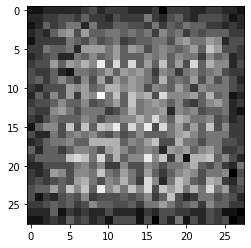

In [12]:
gan.GenerateOutputs(xtest=gan.evaluationInpt,batchSize=16,returnArray=False,dataViewer=vwr,save=True,View=False,epoch=0)
gan.GenerateOutputs(batchSize=1,returnArray=False,dataViewer=vwr,save=False,View=True)

Epoch 1/30
117/117 [==============================] - 134s 1s/step
Discrimiator: (loss,-0.869175136089325)(activation_loss,0.0010509981075301766)(label_loss,0.32877546548843384)(code1_loss,-1.313093662261963)(code2_loss,-1.0849095582962036)(activation_accuracy,1.0)(label_accuracy,0.94140625)(code1_accuracy,0.0)(code2_accuracy,0.0)
 	 Adversial: (loss,-2.816946506500244)(activation_loss,0.0006583263748325408)(label_loss,0.01849997416138649)(code1_loss,-3.060568332672119)(code2_loss,-2.6116414070129395)(activation_accuracy,1.0)(label_accuracy,0.994140625)(code1_accuracy,0.0)(code2_accuracy,0.0)
Epoch 2/30
117/117 [==============================] - 139s 1s/step
Discrimiator: (loss,-1.3448143005371094)(activation_loss,0.013444172218441963)(label_loss,0.17660018801689148)(code1_loss,-1.6002631187438965)(code2_loss,-1.469454050064087)(activation_accuracy,1.0)(label_accuracy,0.9482421875)(code1_accuracy,0.0)(code2_accuracy,0.0)
 	 Adversial: (loss,-3.2387337684631348)(activation_loss,8.447597

Epoch 15/30
117/117 [==============================] - 141s 1s/step
Discrimiator: (loss,-0.9257610440254211)(activation_loss,0.6230970621109009)(label_loss,0.06643275916576385)(code1_loss,-1.5768966674804688)(code2_loss,-1.6536850929260254)(activation_accuracy,0.59765625)(label_accuracy,0.98046875)(code1_accuracy,0.0)(code2_accuracy,0.0)
 	 Adversial: (loss,-1.5590510368347168)(activation_loss,1.748488187789917)(label_loss,0.011205571703612804)(code1_loss,-3.3562052249908447)(code2_loss,-3.2812843322753906)(activation_accuracy,0.009765625)(label_accuracy,1.0)(code1_accuracy,0.0)(code2_accuracy,0.0)
Epoch 16/30
117/117 [==============================] - 141s 1s/step
Discrimiator: (loss,-0.7598952054977417)(activation_loss,0.5436848998069763)(label_loss,0.06587083637714386)(code1_loss,-1.5117077827453613)(code2_loss,-1.22719407081604)(activation_accuracy,0.7236328125)(label_accuracy,0.9794921875)(code1_accuracy,0.0)(code2_accuracy,0.0)
 	 Adversial: (loss,-2.1696765422821045)(activation_

Epoch 29/30
117/117 [==============================] - 139s 1s/step
Discrimiator: (loss,-0.8300780653953552)(activation_loss,0.536984920501709)(label_loss,0.03922406584024429)(code1_loss,-1.4457083940505981)(code2_loss,-1.3668657541275024)(activation_accuracy,0.70703125)(label_accuracy,0.9892578125)(code1_accuracy,0.0)(code2_accuracy,0.0)
 	 Adversial: (loss,-2.3322787284851074)(activation_loss,1.1936508417129517)(label_loss,0.0092550003901124)(code1_loss,-3.4438388347625732)(code2_loss,-3.626530170440674)(activation_accuracy,0.23828125)(label_accuracy,0.998046875)(code1_accuracy,0.0)(code2_accuracy,0.0)
Epoch 30/30
117/117 [==============================] - 139s 1s/step
Discrimiator: (loss,-1.2275117635726929)(activation_loss,0.5810887813568115)(label_loss,0.019903084263205528)(code1_loss,-1.7679545879364014)(code2_loss,-1.8890526294708252)(activation_accuracy,0.7216796875)(label_accuracy,0.9951171875)(code1_accuracy,0.0)(code2_accuracy,0.0)
 	 Adversial: (loss,-1.9245291948318481)(ac

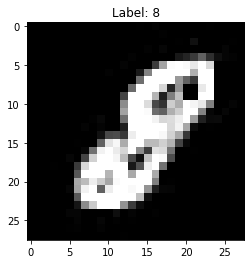

In [13]:
gan.train(x_train=[xtr,ytr],batch_size=1024,epoch=30,evalStep=(1,10),dataViewer=vwr,pathSave='D:/Project/DeepLearning/GAN/InfoGAN/save')

Test the impact of X.
The vector $\forall i \in \mathbb{N}^{\star}  X_i \sim \mathcal{N}(0,1)$ so 99% of the value are in the range $[-3;3]$.

In [14]:
def compareX(digit):
    x = np.asarray([i*(6/10) -3  for i in range(11)])
    evl = gan.rdmGenInput(batchSize=1)
    evl[1] = np.zeros([1, 10])
    evl[1][0,digit] = 1
    for i in x:
        #row    
        for j in x:
            #Column
            evl[2] = np.array([[i]]).reshape((1,1))
            evl[3] = np.array([[j]]).reshape((1,1))
            #Get the generate mnist
            mtr = gan.generator.predict(evl)
            mtr = mtr.reshape((28,28))
            #construct the line
            if j == x[0]:
                line = mtr
            else:
                line = np.concatenate([line,mtr] ,axis= 1)
        if i == x[0]:
            #if first row
            res = line
        else:
            res = np.concatenate([res,line],axis= 0  )

    plt.imshow(res, cmap='gray')
    plt.title('Impact of X vector on the nubmer {}'.format(digit))
    plt.savefig('D:/Project/DeepLearning/GAN/InfoGAN/output/digit_{}.jpg'.format(digit))

for i in range(10):
    compareX(i)